In [3]:
# mount to my google drive to access the necessary files and 
# to save newly created files to drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# sys will allow us to open our class files (dataset and gan) for use as imports

import sys
sys.path.append('/content/drive/MyDrive/Chapman/510/Project/Classes')
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 4.6 MB/s 


In [14]:
# import the necessary packages

import tensorflow as tf 
import dataset as ds
import gan
from pathlib import Path
import zipfile
import csv
import time
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

In [6]:
# get all files from the training dataset into the runtime before we start having to do everything else
# this should make the program run much faster than having to load each file just-in-time

zippath = 'drive/MyDrive/Chapman/510/Project/sims.zip'

print('unzipping files in runtime environment. this will take ~10 seconds.')

start = time.time()

sims = zipfile.ZipFile(zippath, 'r')
sims.extractall(path='/')
sims.close()

end = time.time()

print('...done in', str(round((end-start), 2)), 'seconds')

unzipping files in runtime environment. this will take ~10 seconds.
...done in 4.0 seconds


In [ ]:
'''
Intro to the dataset

This dataset comprises 10100 sine waves, each with 1024 timesteps. The database was created by me using a short
program (create_sines.ipynb in the github repo).

Each sine wave uses a unique combination of amplitude and frequency to create a unique sine wave.
The amplitude is a numeric variable that is uniformly distributed in [0.33, 0.67] for 101 total unique amplitudes.
Frequency is also a numeric variable uniformly distributed in [1, 100] for 100 total unique frequencies.

There is also a metadata file (METADATA.csv) that tracks the name of the file, the amplitude and frequency of the
sine wave.

Since these files were created by me for this project, there are no missing values and neither any of the 10100
training files nor the metadata file need to be modified or cleaned/preprocessed in any way.

As both variables are independent and uniformly distributed, there should be no correlation between amplitude
and frequency, as the 2D histogram below shows.
'''

dataframe columns:  Index(['sim', 'freq', 'amp'], dtype='object') 



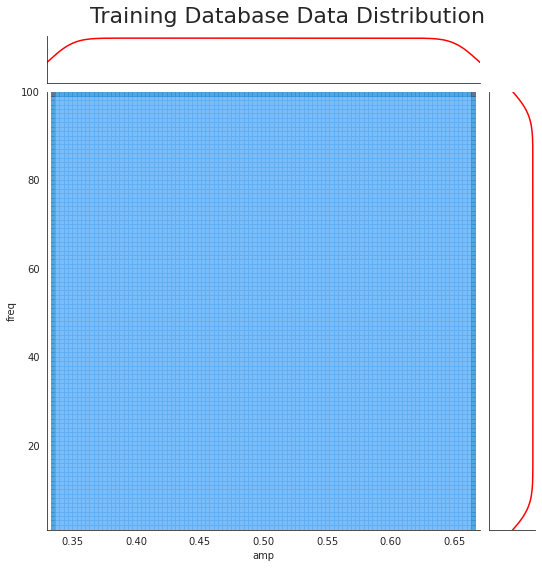

In [23]:
# print a distribution of the training set's key variables 

metadata    = metadata = 'drive/MyDrive/Chapman/510/Project/METADATA.csv'
mdat        = pd.read_csv(metadata, sep='\t')
print('dataframe columns: ', mdat.columns, '\n')

sns.set_style('white')
sp = sns.JointGrid(x=mdat['amp'], y=mdat['freq'], height=8, ratio=8)
sp.plot_joint(sns.histplot, alpha=0.8, bins=99)
sp.fig.suptitle('Training Database Data Distribution', fontsize=22)
sp.plot_marginals(sns.kdeplot, color='r')
sp.fig.subplots_adjust(top=0.93, right=0.93)
sp.ax_marg_x.set_xlim(0.33, 0.67)
sp.ax_marg_y.set_ylim(1.0, 100)
sns.despine()

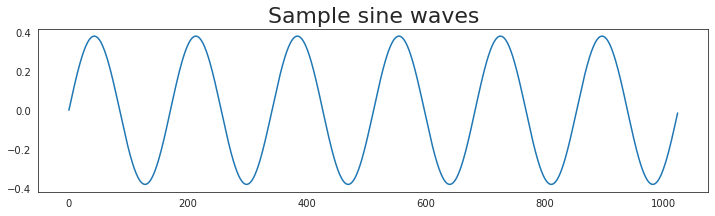

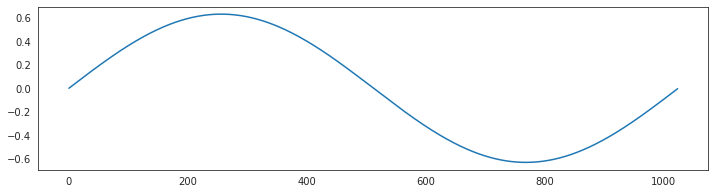

In [24]:
# print an example of some sine waves in the training set. note that both amplitude and frequency 
# changes from the first example to the second. 

pathway = '/sims'

pw = pathway + '/520.csv'
data = pd.read_csv(pw, sep='\t')
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax.plot(data['time'], data['wave'])
plt.title('Sample sine waves', fontsize=22)
plt.show()

pw = pathway + '/90.csv'
data = pd.read_csv(pw, sep='\t')
fig, ax = plt.subplots(1, 1, figsize=(12,3))
ax.plot(data['time'], data['wave'])
plt.show()

In [ ]:
'''
GOAL

The goal of this project is to test a GAN's ability to successfully interpret numeric, non-categorical labels
(amplitude and frequency in this case) and to correctly output sine waves with a matching amplitude and frequency.
Interpreting continuous (non-binned) numeric data is an ongoing point of research in machine learning. GANs in 
particular have historically struggled in dealing with numeric labels and tend to bin data into chunks, for example 
potentially treating any number between 0 and 0.2 as being "near" 0.1, therefore all outputs for any number within 
that range will look the same. This is certainly a problem; an amplitude of 0.2 is certainly much different than 
an amplitude of 0.1.

The GAN for this project therefore accepts only the values for amplitude and frequency as the first layer of the 
generator (no noise is added as amplitude and frequency are expected to be complete and sufficient data to recreate
the sine waves), then attempts to recreate the intended sine wave time series using these values.

It is worth noting that this was a fairly robust machine learning model; while this program executes the main training
loop, the actual GAN architecture can be found in "/Classes/gan.py" and the handling of the training data files,
metadata, and GAN outputs can be found in "/Classes/dataset.py".
'''

In [ ]:
# define key variables/arguments

loadweights = True
usebias     = True
amsgrad     = False
labs        = 2
glr         = 1e-2
dlr         = 1e-2
b1          = 0.3
b2          = 0.8
nrns        = 512
r1g         = 1e0
epsln       = 1e-5
res         = 1024
bsize       = 32
ksize       = 9

In [ ]:
# pathways to save files to
outpath  = f'drive/MyDrive/Chapman/510/Project/Outs/{nrns}n_{glr}_{dlr}_c'
weights  = f'drive/MyDrive/Chapman/510/Project/Outs/{nrns}n_{glr}_{dlr}_b/weights'
epoch = str(213000)

# save some of the data about the run to the attrs file, in case we want to look this info up later
Path(outpath).mkdir(exist_ok=True)
with open(outpath + '/attrs.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['loadweights', loadweights])
    writer.writerow(['usebias', usebias])
    writer.writerow(['neurons', nrns])
    writer.writerow(['g learning rate', glr])
    writer.writerow(['d learning rate', dlr])
    writer.writerow(['r1gamma', r1g])
    writer.writerow(['epsilon', epsln])
    writer.writerow(['resolution', res])
    writer.writerow(['batch size', bsize])
    writer.writerow(['beta1', b1])
    writer.writerow(['beta2', b2])

# load the dataset
dataset = ds.Dataset(batch_size=bsize, pathway=pathway, mdpath=metadata, outpath=outpath, endres=res)

# call the GAN class
msgg = gan.MSG_GAN_ts(neurs=nrns, endres=res, g_lr=glr, d_lr=dlr, r1_gamma=r1g, epsilon=epsln, 
                        outpath=outpath, epochs=1000000, nchannels=1, ksize=ksize, usebias=usebias, nlabels=labs,
                        beta1=b1, beta2=b2, amsgrad=amsgrad, batch_size=bsize)

# continue from previous save point?
if loadweights == True:
    msgg.D.load_weights(weights + '/discriminator' + epoch + '.h5')
    msgg.G.load_weights(weights + '/generator' + epoch + '.h5')

# start the training loop
msgg.train(dataset)

In [ ]:
'''
Evaluation and discussion

Both the evaluation of results and discussion of findings and future work can be found in the file 
"report_samples.ipynb" in the "/Reports" folder of this repo.
'''